## Convolutional Autoencoders

This notebook is an autoencoder for MNIST.  Noise is added to the input, so this autoencoder performs image reconstruction from noisy input.  

1 Review the code blocks and how the encoder-decoder works, especially make sure you see how the functional API works for building models  (https://keras.io/guides/functional_api/)

2 Run the code and observe results

3 Add skip connections then rerun- do skip connections help?
  look for the <<<<<<<<--------- markers

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare the Dataset

In [2]:
#Load MNIST data from Keras datasets
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

X_train=X_train[0:1000,]  #only need smaller subset to get good results
Y_train=Y_train[0:1000,]

# --------- Reshape input data, b/c Keras expects N-3D images (ie 4D matrix)
X_train = X_train[:,:,:,np.newaxis]
X_test  = X_test[:,:,:,np.newaxis]

#Scale 0 to 1  - or should we not scale
X_train = X_train/255.0
X_test  = X_test/255.0

# Convert 1-dimensional class arrays to 10-dimensional class matrices
#Y_train = keras.utils.to_categorical(Y_train, 10)
#Y_test  = keras.utils.to_categorical(Y_test,  10)

# ------------- End loading and preparing data --------------
print('X train shape:', X_train.shape) 
print('X test shape:', X_test.shape) 


X train shape: (1000, 28, 28, 1)
X test shape: (10000, 28, 28, 1)


In [3]:
#Add some noise to make it harder
def addnoise(X):
    X=X + np.round(np.random.uniform(-1,1,size=X.shape) )
    X[np.where(X>1)]=1
    X[np.where(X<0)]=0
    return X
X_train_wnoise = addnoise(X_train)
X_test_wnoise  = addnoise(X_test)
print('noise added')

noise added


## Define the Model

This will use convolutional layers to build the model. This is composed of three main parts: encoder, bottleneck, and decoder. You will follow the configuration shown in the image below.

<img src="https://drive.google.com/uc?export=view&id=15zh7bst9KKvciRdCvMAH7kXt3nNkABzO" width="75%" height="75%"/>

The encoder will contract with each additional layer. The features are generated with the Conv2D layers while the max pooling layers reduce the dimensionality.

In [4]:
def encoder(inputs):
  '''Defines the encoder with two Conv2D and max pooling layers.'''
  conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
                                                                     #padding same produces same output size
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1) #max pooling does the downsampling

  conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

  return max_pool_2, conv_1, conv_2   #<<<<------Notice this returns the last layer and intermediate ones

A bottleneck layer is used to get force a smaller dimensional space of features and/or maps
Here, I'm using only 16 filter in part to make it harder instead of 256 like in the picture

In [5]:
def bottle_neck(inputs):
  '''Defines the bottleneck.''' 
  bottle_neck = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same',name='thebottleneck')(inputs)
  
  return bottle_neck

## Add a skip connection with concatenation here 

The decoder will upsample the bottleneck output back to the original image size. 

To add a skip connection, first match up the correct encoding output to the decoding input, so that he feature maps are the same size 

Use the tensorflow concatenation function as described here:

https://keras.io/api/layers/merging_layers/concatenate/

In [6]:
def decoder(inputs, enc_conv1,enc_conv2):
  '''Defines the decoder path to upsample back to the original image size.'''
  #Notice that padding = same keeps the output same size as input 
  
  conv_1      = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

#another optoin is transpose
# up_sample_1 = tf.keras.layers.Conv2DTranspose(128,kernel_size=(2,2),strides=(2,2))(conv_1)
# in a transpose convolutional layer, 

  # --------->>>>> before the conv_2 line add a 
  # --------->>>>        tf.keras.layers.concatenate statement to combine enc_conv2 with decoding up_sample_1
  #  conv_2      = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)

  skip_concat_1 = tf.keras.layers.concatenate([up_sample_1, enc_conv2])
  conv_2      = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(skip_concat_1)
                                     # ---------->>>> and change the input into conv_2
  
  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)
    
  #---->>> add another concatenation here to combine up_sample_2 and enc_conv1
  # conv_3      = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)
  skip_concat_2 = tf.keras.layers.concatenate([up_sample_2, enc_conv1])
  conv_3      = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(skip_concat_2)


  return conv_3

You can now build the full autoencoder using the functions above.



In [7]:
def convolutional_auto_encoder():
  '''Builds the entire autoencoder model.'''
  inputs                                     = tf.keras.layers.Input(shape=(28, 28, 1,))
  encoder_output, enc_conv1_output, enc_conv2_output = encoder(inputs)
  bottleneck_output                          = bottle_neck(encoder_output)
  decoder_output                             = decoder(bottleneck_output, enc_conv1_output, enc_conv2_output)
  
  model         = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  return model



In [8]:
convolutional_model = convolutional_auto_encoder()
convolutional_model.summary() 



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 64)   640         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 128)  73856       ['max_pooling2d[0][0]']          
                                                                                              

2023-06-28 23:30:17.260561: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-28 23:30:17.260597: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (exp-10-36): /proc/driver/nvidia/version does not exist
2023-06-28 23:30:17.260876: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Compile and Train the model

In [9]:
myES_function = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(X_train_wnoise,X_train, 
                                             validation_data=(X_test_wnoise,X_test),
                                             batch_size=128,
                                             epochs=20,callbacks=[myES_function])


Epoch 1/20
8/8 [==============================] - 6s 773ms/step - loss: 0.5391 - val_loss: 0.4530
Epoch 2/20
8/8 [==============================] - 6s 820ms/step - loss: 0.4183 - val_loss: 0.3754
Epoch 3/20
8/8 [==============================] - 6s 830ms/step - loss: 0.3158 - val_loss: 0.2468
Epoch 4/20
8/8 [==============================] - 6s 829ms/step - loss: 0.2192 - val_loss: 0.2003
Epoch 5/20
8/8 [==============================] - 6s 859ms/step - loss: 0.1865 - val_loss: 0.1753
Epoch 6/20
8/8 [==============================] - 6s 824ms/step - loss: 0.1686 - val_loss: 0.1642
Epoch 7/20
8/8 [==============================] - 6s 808ms/step - loss: 0.1615 - val_loss: 0.1603
Epoch 8/20
8/8 [==============================] - 7s 912ms/step - loss: 0.1572 - val_loss: 0.1605
Epoch 9/20
8/8 [==============================] - 6s 869ms/step - loss: 0.1558 - val_loss: 0.1560
Epoch 10/20
8/8 [==============================] - 7s 959ms/step - loss: 0.1526 - val_loss: 0.1533
Epoch 11/20
8/8 [==

## Display sample results

As usual, let's see some sample results from the trained model.

In [10]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_predicted, 20, shape=(28,28,))

1/1 [==============================] - 0s 99ms/step


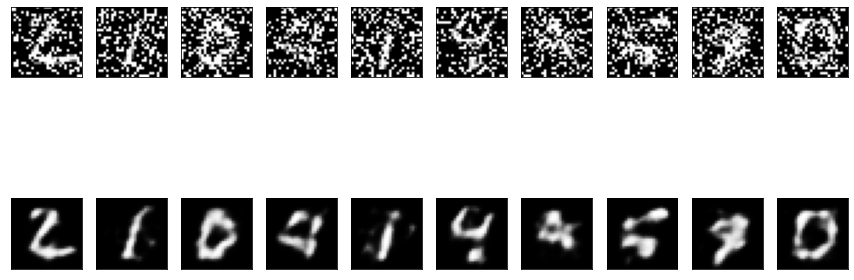

In [11]:
# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(X_test_wnoise[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# get a prediction for some values in the dataset
predicted = convolutional_model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, predicted, enc_shape=(7,7))